# Coursework 1 : The three body problem

You should complete your coursework in this notebook and hand it in *via QMPlus* by 5pm on Friday of week 9 (24 November).

The broad goal of the project is to write code to model coplanar stellar systems (i.e., all the motion is in the x and y directions) with up to three stars.

## Your code must model the following 3 scenarios

1. A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic). The stars obey Newton's law:

    $\vec{F}_{12} = - \frac{G m_1 ~ m_2 }{|r_{12}|^2} \frac{\vec{r}_{12}}{|\vec{r}_{12}|}$

    (You can work in units in which we set $G=1$ and the masses are order 1 numbers, but you can also choose to work in real units, as you prefer.)

2. A three body system made up of 3 stars of equal mass. Stars are assumed to be point like objects and so they cannot collide with each other (they simply pass through if at the same location). Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

3. You now have a system of hypergiants. Hypergiants are the most massive stars, and so they cannot be treated as point like objects. Now if they get within some distance of each other, they should merge (*HINT: maybe we could say that they "add" themselves...*) into a single hypergiant with a combined mass of the two objects. Since momentum is conserved, we will also require that:

    $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$

    In this case, set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2. You can choose the distance at which they merge, but it should be proportional to the masses of the two objects that are merging.

## Required components

To obtain full marks your solutions must include the following components:

1. Classes for stars, supergiants and stellar systems with multiple star components. Use of inheritance where possible and appropriate 

_(HINT: try to think ahead - what features of scenario 1 might you want to reuse in scenarios 2 and 3? You can save time coding by making it sufficiently general from the start.)_

2. Plots of the orbital trajectories of the stars over time

3. Phase diagrams for the position and velocities of the component stars.

4. Comparison of two explicit integration techniques - the first should be scipy's solve_ivp() and the second should be the midpoint method (or another Runge Kutta method of specified order). For the latter you should confirm the order of convergence of the solution is as expected.

_(HINT: you may want to investigate the rtol parameter for solve_ivp().)_

5. Documentation of the code appropriate for new users who have a basic familiarity with python and ODEs (your colleagues on this course, for example!), implemented in markdown around the code blocks.

6. Defensive programming techniques including asserts and tests of key functionality


## Marking scheme

   - 50% for working code that correctly implements all of the requested physical scenarios
   - 20% for use of defensive programming techniques - asserts and tests implemented to prevent user error and check functioning correctly, including a convergence test
   - 20% for readability of code, following the agreed naming conventions of the course, appropriate commenting
   - 10% for appropriate documentation of the code implemented in markdown format


---

### Imports

In [52]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Star and HyperGiant classes
The two classes Star and HyperGiant are presented bellow. The HyperGiant class differs from the Star only in the fact that it has a radius. This is because the HyperGiants are not point-like objects, and so they cannot pass through each other. Instead, they merge into a single HyperGiant with a combined mass. I've implemented asserts to check the user is inputting the correct data types and values.

In [53]:
# Class: star
class Star():
    """
    A class used to represent a star.

    Attributes
    ----------
    name : str
        The name of the star.
    mass : float
        The mass of the star.
    starting_position : numpy.ndarray
        The starting position of the star.
    starting_velocity : numpy.ndarray
        The starting velocity of the star.
    radius : float
        The radius of the star. Equal to 0 for stars.
    """

    def __init__(self, name, mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([0,0])):
        assert isinstance(name, str), "Name must be of type string"
        assert starting_position.shape == (2,), "Starting position must be a 2D vector"
        assert starting_velocity.shape == (2,), "Starting velocity must be a 2D vector"
        assert mass > 0, 'mass must be positive'

        self._name = name
        self._mass = mass
        self._starting_position = starting_position
        self._starting_velocity = starting_velocity
        self._radius = 0

    @property
    def name(self):
        return self._name
    
    @name.setter
    def name(self, name):
        assert isinstance(name, str), "Name must be of type string"
        self._name = name

    @property
    def mass(self):
        return self._mass
    
    @mass.setter
    def mass(self, mass):
        assert mass >= 0, 'mass can\'t be negative'
        self._mass = mass

    @property
    def starting_position(self):
        return self._starting_position
    
    @starting_position.setter
    def starting_position(self, starting_position):
        assert starting_position.shape == (2,), "Starting position must be a 2D vector"
        self._starting_position = starting_position

    @property
    def starting_velocity(self):
        return self._starting_velocity
    
    @starting_velocity.setter
    def starting_velocity(self, starting_velocity):
        assert starting_velocity.shape == (2,), "Starting velocity must be a 2D vector"
        self._starting_velocity = starting_velocity

    @property
    def radius(self):
        return self._radius

In [54]:
class HyperGiant(Star):
    def __init__(self, name, mass, starting_position, starting_velocity):
        super().__init__(name, mass, starting_position, starting_velocity)
        self.update_radius()

    # I've used a simple formula to calculate the radius of the star given its mass
    def update_radius(self):
        self._radius =  self.mass * 0.03

### Stellar System class
Here is my StellarSystem class. The functions available to the user are *add_star*, *calculate_movement*, and the plotting functions -- *plot_movement*, *plot_center_of_mass*, *plot_phase_diagram*, *plot_collision_coordinates* and *plot_final_positions*. Each function is documented in the code. I've implemented assets to check the correct variable types are passed to the functions and to check whether the functionsa re calle in the correct order.

In [55]:
# Stellar systems
class StellarSystem():
    """
    A class used to represent a stellar system.

    Attributes
    ----------
    name : str
        The name of the stellar system.
    integration_method : str
        The integration method to use.
    list_of_stars : numpy.ndarray
        The list of stars in the system.
    y_solution : numpy.ndarray
        The solution to the system of ODEs.
    t_solution : numpy.ndarray
        The time solution.
    max_time : float
        The maximum time to integrate to.
    N_time_steps : int
        The number of time steps to use.
    delta_t : float
        The time step.
    gravity : float
        The gravitational constant.
    colors : list
        The list of colours to use for plotting.
    centre_of_mass : numpy.ndarray
        The centre of mass of the system.  
    
    Methods
    -------
    add_star(star)
        Add a star to the system.
    calculate_movement()
        Calculate the movement of the stars in the system.
    plot_movement(ax, plot_centre_of_mass=False)
        Plot the movement of the stars in the system.
    plot_centre_of_mass(ax, color='r')
        Plot the centre of mass of the system.
    plot_collision_coordinates(ax)
        Plot the collision coordinates of the system as a scatter plot.
    plot_phase_plot(ax, index=0)
        Plot the phase plot of the system.
    plot_final_positions(ax)
        Plot the final positions of the stars in the system.
    """

    integration_methods = ["RK45", "MidPoint"]

    def __init__(self, max_time=50,  N_time_steps=250 , integration_method='RK45', name=''):
        # Integration parameters
        self._is_defined = False
        self._max_time = max_time
        self._N_time_steps = N_time_steps
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        self._y_solution = np.zeros_like(self._t_solution)
        self._integration_method = integration_method
        assert self.integration_method in self.integration_methods, 'Integration method not supported - choose either RK45 or MidPoint'
        assert self.max_time > 0, 'max_time must be positive'
        assert self.N_time_steps > 0, 'N_time_steps must be positive'

        # Stellar system parameters
        self.name = name
        assert isinstance(self.name, str), 'Name must be of type string'
        self._hypergiants = False
        self._gravity = 1
        self._center_of_mass = np.empty((2,0))
        self._temp_sol = {}

        # Star variables
        self._list_of_stars = np.array([], dtype=Star)

        # Plotting variables
        self._movement_plotted = False
        self._colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    @property
    def y_solution(self):
        return self._y_solution
    
    @property
    def t_solution(self):
        return self._t_solution
    
    @property
    def max_time(self):
        return self._max_time
    
    @property
    def N_time_steps(self):
        return self._N_time_steps
    
    @property
    def list_of_stars(self):
        return self._list_of_stars
    
    @property
    def integration_method(self):
        return self._integration_method
    
    @property
    def delta_t(self):
        return self._delta_t
    
    @property
    def gravity(self):
        return self._gravity

    @property
    def colors(self):
        return self._colors
    
    @property
    def centre_of_mass(self):
        return self._centre_of_mass

    @max_time.setter
    def max_time(self, value):
        self._max_time = value
        assert self.max_time > 0, 'max_time must be positive'
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros_like(self._t_solution)
    
    @N_time_steps.setter
    def N_time_steps(self, value):
        self._N_time_steps = value
        assert self.N_time_steps > 0, 'N_time_steps must be positive'
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros_like(self._t_solution)

    @gravity.setter
    def gravity(self, value):
        self._gravity = value
        assert self.gravity > 0, 'gravity must be positive'

    @integration_method.setter
    def integration_method(self, value):
        assert value in self.integration_methods, 'Integration method not supported - choose either RK45 or MidPoint'
        self._integration_method = value

    @colors.setter
    def colors(self, value):
        assert type(value) == list, "colors must be a list"
        self._colors = value


    def add_star(self, star):
        """
        Add a star to the system.

        Parameters:
        star (Star): The star to add to the system.
        """
        assert isinstance(star, Star) or isinstance(star, HyperGiant), 'Star must be of type Star or HyperGiant'
        
        # Update system variables
        self._list_of_stars = np.append(self._list_of_stars, star)
        
        # Define system if there are at least two stars
        if len(self._list_of_stars) > 1:
            self._is_defined = True


    def _update_stellar_parameters(self, initial=False):
        """
        Update the stellar parameters. This function is called once before the integration starts and then every time a collision occurs.

        Parameters:
        initial (bool): Whether this is the first time the function is called or not.
        """
        self._list_of_giants = np.array([], dtype=bool)
        self._masses = np.array([], dtype=float)
        self._radii = np.array([], dtype=float)
        self._assimilated = np.array([], dtype=bool)

        for _, star in enumerate(self._list_of_stars):
            self._masses = np.append(self._masses, star.mass)
            self._radii = np.append(self._radii, star.radius)
            self._list_of_giants = np.append(self._list_of_giants, isinstance(star, HyperGiant))
            self._assimilated = np.append(self._assimilated, [True if star.mass == 0 else False])

            if isinstance(star, HyperGiant):
                # Make the system one of hypergiants
                self._hypergiants = True
                
                # Ensure hypergiants are the largest stars in the system
                if sum(np.logical_not(self._list_of_giants)) > 0:
                    max_mass_normal_star = np.max(self._masses[np.logical_not(self._list_of_giants)])
                    assert star.mass > max_mass_normal_star, 'Hypergiants must be the most massive stars in the system'
                assert self.integration_method == "MidPoint", "Hypergiants can only be simulated using the MidPoint method"
            else:
                # Ensure hypergiants are the largest stars in the system
                if sum(self._list_of_giants) > 0:
                    min_mass_hypergiant = np.min(self._masses[self._list_of_giants])
                    assert star.mass < min_mass_hypergiant, 'Normal stars must be the least massive stars in the system'

        if initial and self._hypergiants:
            self._masses_over_time = self._masses
            self._collision_coordinates = {}


    def _solve_odes(self, t, conditions, half_step=False):
        """
        Solve the system of ODEs.

        Parameters:
        t (float): The time.
        conditions (numpy.ndarray): The conditions.
        half_step (bool): Whether to use half step or not.

        Returns:
        numpy.ndarray: The solution to the system of ODEs.
        """
        # Initialise dydt
        dydt = np.zeros_like(conditions)

        if self._hypergiants:
        
            # Check for collisions

            for index1, star1 in enumerate(self._list_of_stars):

                for index2, star2 in enumerate(self._list_of_stars):

                    if index1 != index2 and self._assimilated[index1] == 0 and self._assimilated[index2] == 0 and np.sqrt(sum((conditions[4*index1:4*index1 + 2] - conditions[4*index2:4*index2 + 2])**2)) < sum(self._radii[[index1, index2]]):

                        # There is a collision!

                        if self._masses[index1] == self._masses[index2]:
                            # If the masses are equal, choose one of the stars at random to be the smaller one
                            indexes = [0,1]
                            np.random.shuffle(indexes)
                            index_small = [index1, index2][indexes[0]]
                            star_small = [star1, star2][indexes[0]]
                            index_large = [index1, index2][indexes[1]]
                            star_large = [star1, star2][indexes[1]]
                        else:
                            # Find the index of the smaller star
                            index_small = [index1, index2][np.argmin(self._radii[[index1, index2]])]
                            star_small = [star1, star2][np.argmin(self._radii[[index1, index2]])]
                            # Find the index of the larger star
                            index_large = [index1, index2][np.argmax(self._radii[[index1, index2]])]
                            star_large = [star1, star2][np.argmax(self._radii[[index1, index2]])]

                        # Update conditions
                        new_conditions = (self._masses[index_small] * conditions[4*index_small:4*index_small + 4] + self._masses[index_large] * conditions[4*index_large:4*index_large + 4]) / (self._masses[index_small] + self._masses[index_large])
                        conditions[4*index_large:4*index_large + 4] = np.array(new_conditions)
                        conditions[4*index_small:4*index_small + 4] = np.array([0, 0, 0, 0])
                        self._collision_coordinates[index_small] = new_conditions[0:2]

                        # Set temporary solution
                        self._temp_sol[int(t/self._delta_t)] = [conditions, half_step]

                        # Make the smaller star mass, radius, velocity, and position 0
                        star_small.mass = 0
                        star_small.update_radius()

                        # Calculate the new mass and radius of the larger star
                        star_large.mass = self._masses[index_small] + self._masses[index_large]
                        star_large.update_radius()

                        # Update the masses and radii
                        self._update_stellar_parameters()

            if not half_step:
                # Save the masses at this time step
                self._masses_over_time = np.vstack([self._masses_over_time, self._masses])

        # ODEs
        for index, _ in enumerate(self._list_of_stars):
            # If star has been assimilated, set all conditions to 0
            if self._assimilated[index]:
                conditions[4*index:4*index + 4] = np.array([0, 0, 0, 0])
                dydt[4*index:4*index + 4] = np.array([0, 0, 0, 0])
            
            # If the star is the only one left, no forces act on it
            elif sum(self._assimilated) == len(self._list_of_stars) - 1:
                dydt[4*index + 0] = conditions[4*index + 2]
                dydt[4*index + 1] = conditions[4*index + 3]
                dydt[4*index + 2] = 0
                dydt[4*index + 3] = 0

            # If the star is not the only one left, calculate the forces acting on it
            else:
                dydt[4*index + 0] = conditions[4*index + 2]
                dydt[4*index + 1] = conditions[4*index + 3]
                dydt[4*index + 2] = - self._gravity * sum(self._masses[i] * (conditions[4*index + 0] - conditions[4*i + 0]) / 
                                                (np.linalg.norm(conditions[4*index:4*index + 2] - conditions[4*i:4*i + 2]) ** 3) for i in range(len(self.list_of_stars)) if i != index)
                dydt[4*index + 3] = - self._gravity * sum(self._masses[i] * (conditions[4*index + 1] - conditions[4*i + 1]) / 
                                                (np.linalg.norm(conditions[4*index:4*index + 2] - conditions[4*i:4*i + 2]) ** 3) for i in range(len(self.list_of_stars)) if i != index)

        return dydt
    

    def _integrate_using_midpoint(self, dydt_function, y0):
        """
        Integrate the system of ODEs using the MidPoint method.

        Parameters:
        dydt_function (function): The function to integrate.
        y0 (numpy.ndarray): The initial conditions.
        """
        # Initialise the solution
        self._y_solution = np.zeros((len(self._t_solution), len(y0)))
        
        for itime, time in enumerate(self._t_solution) :
            if itime == 0:
                self._y_solution[itime] = np.array(y0)
            else :
                # Whenever a collision occurs, I use a temporary solution which acts as the solution in the prevoius time step.
                # A collision can occur both at the half step and at the full step and this is why I need to check both.
                change_at_t_over_2 = (1/2) * self._delta_t * dydt_function(time, self._y_solution[itime-1], half_step=True)
                
                if itime in self._temp_sol.keys() and self._temp_sol[itime][1]:
                    y_at_t_over_2 = self._temp_sol[itime][0] + change_at_t_over_2
                else:
                    y_at_t_over_2 = self._y_solution[itime-1] + change_at_t_over_2
                
                change = self._delta_t * dydt_function(time + self._delta_t, y_at_t_over_2)

                if itime+1 in self._temp_sol.keys():
                    self._y_solution[itime] = self._temp_sol[itime+1][0] + change
                else:
                    self._y_solution[itime] = self._y_solution[itime-1] + change

        self._y_solution = self._y_solution.transpose()
   

    def calculate_movement(self):
        """
        Calculate the movement of the stars in the system. The solution is stored in y_solution.
        """
        assert self._is_defined, "System is not defined, add at least two stars"

        # Update stellar parameters
        self._update_stellar_parameters(initial=True)

        # Initial conditions
        initial_conditions = np.zeros(len(self._list_of_stars) * 4)    
        for index, star in enumerate(self._list_of_stars):
            initial_conditions[4*index + 0] = star.starting_position[0]
            initial_conditions[4*index + 1] = star.starting_position[1]
            initial_conditions[4*index + 2] = star.starting_velocity[0]
            initial_conditions[4*index + 3] = star.starting_velocity[1]

        # Solve ODEs
        if self.integration_method == 'RK45':
            # Get the solution
            self._y_solution = solve_ivp(self._solve_odes, [0, self.max_time], initial_conditions, t_eval=self._t_solution, method='RK45', rtol=1e-10).y
        if self.integration_method == 'MidPoint':
            self._integrate_using_midpoint(self._solve_odes, initial_conditions)


    def plot_movement(self, ax):
        """
        Plot the movement of the stars in the system.

        Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axes to plot on.
        """
        assert not np.array_equal(self._y_solution, np.zeros_like(self._t_solution)), "No solution found, calculate the movement of the stars first"
        assert isinstance(ax, plt.Axes), "ax must be of type matplotlib.axes._subplots.AxesSubplot"

        self._movement_plotted = True

        # Plot the star trajectories
        for index, star in enumerate(self._list_of_stars):
                
                stop = len(self._y_solution[0])

                # Find the index at which the star is assimilated
                for i in range(len(self._y_solution[0])):
                    if self._y_solution[4*index + 0][i] == 0 and self._y_solution[4*index + 1][i] == 0 and self._y_solution[4*index + 2][i] == 0 and self._y_solution[4*index + 3][i] == 0 and i != 0:
                        stop = i
                        break
                
                ax.plot(self._y_solution[4*index + 0][:stop], self._y_solution[4*index + 1][:stop], alpha=0.7, label=star.name, color=self.colors[index])
           
        ax.legend()
        ax.grid()
        ax.set_xlabel("x", fontsize=16)
        ax.set_ylabel("y", fontsize=16)
        ax.set_title(f"{self.name} ({self.integration_method})", fontsize=16)


    def plot_centre_of_mass(self, ax, color='r'):
        """
        Plot the centre of mass of the system.

        Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axes to plot on.
        color (str): The colour of the centre of mass. Default is red.
        """

        assert self._movement_plotted, "Movement of stars must be plotted first"
        assert isinstance(ax, plt.Axes), "ax must be of type matplotlib.axes._subplots.AxesSubplot"

        if not self._hypergiants:
            # Calculation and plotting if collision is not allowed
            self._centre_of_mass = np.array([sum(self._masses[i] * self._y_solution[4*i +j] for i, _ in enumerate(self._list_of_stars)) / np.sum(self._masses) for j in range(2)])

            # Plot the centre of mass either as a point or a line
            if np.abs(self._centre_of_mass[0][0] - self._centre_of_mass[0][-1]) < 0.000001 and np.abs(self._centre_of_mass[1][0] - self._centre_of_mass[1][-1]) < 0.000001:
                ax.scatter(self._centre_of_mass[0][0], self._centre_of_mass[1][0], label='Centre of mass', color=color)
            else:
                ax.plot(self._centre_of_mass[0], self._centre_of_mass[1], label='Centre of mass', color=color)
        
        else:
            # Calculation and plotting if collision is allowed
            self._centre_of_mass = np.array([[np.dot(self._masses_over_time[i], self._y_solution[j::4,i]) / sum(self._masses_over_time[i]) for j in range(2)] for i in range(len(self._y_solution[0]))])

            # Plot the centre of mass either as a point or a line
            if np.abs(self._centre_of_mass[0][0] - self._centre_of_mass[-1][0]) < 0.000001 and np.abs(self._centre_of_mass[0][1] - self._centre_of_mass[-1][1]) < 0.000001:
                ax.scatter(self._centre_of_mass[0][0], self._centre_of_mass[0][1], label='Centre of mass', color=color)
            else:
                ax.plot(self._centre_of_mass[:,0], self._centre_of_mass[:,1], label='Centre of mass', color=color)

        ax.legend()
    

    def plot_collision_coordinates(self, ax):
        """
        Plot the collision coordinates of the system as a scatter plot.

        Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axes to plot on.
        """
        assert self._hypergiants, "Collision coordinates can only be plotted for systems with hypergiants"
        assert self._movement_plotted, "Movement of stars must be plotted first"
        assert isinstance(ax, plt.Axes), "ax must be of type matplotlib.axes._subplots.AxesSubplot"

        # Plot the collision coordinates
        if len(self._collision_coordinates) > 0:
            for _, (key, value) in enumerate(self._collision_coordinates.items()):
                ax.scatter(value[0], value[1], label=f'Star {self._list_of_stars[key].name} assimilated', color=self.colors[key])

        ax.legend()


    def plot_phase_plot(self, ax, index=0):
        """
        Plot the phase plot of the system.

        Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axes to plot on.
        index (int): The index of the star to plot the phase plot for.
        """       
        assert not np.array_equal(self._y_solution, np.zeros_like(self._t_solution)), "No solution found, calculate the movement of the stars first"
        assert index < len(self._list_of_stars), "Index must be less than the number of stars in the system"
        assert isinstance(index, int), "Index must be an integer"
        assert isinstance(ax, plt.Axes), "ax must be of type matplotlib.axes._subplots.AxesSubplot"

        ax.grid()
        ax.set_xlabel("x, y", fontsize=16)
        ax.set_ylabel("dx, dy", fontsize=16)
        ax.set_title(f"Phase plot of {self._list_of_stars[index].name} from {self.name}", fontsize=16) 

        ax.plot(self._y_solution[index], self._y_solution[index+2], label=f"f(x) = dx/dt for {self._list_of_stars[index].name}")    
        ax.plot(self._y_solution[index+1], self._y_solution[index+3], label=f"f(y) = dy/dt for {self._list_of_stars[index].name}")

        ax.legend()

    def plot_final_positions(self, ax):
        """
        Plot the final positions of the stars in the system.

        Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axes to plot on.
        """
        assert self._movement_plotted, "Movement of stars must be plotted first"
        assert isinstance(ax, plt.Axes), "ax must be of type matplotlib.axes._subplots.AxesSubplot"

        # Plot the final positions of the stars
        for index, star in enumerate(self._list_of_stars):
            if not self._assimilated[index]:
                ax.scatter(self._y_solution[4*index + 0][-1], self._y_solution[4*index + 1][-1], label=f"Final position of {star.name}", color=self.colors[index])
        
        ax.legend()

---

## Part 1: Two body system

Let's start with the two body system where the two stars orbit each other. To make sure that the system is stable, we require that the total momentum is equal to zero:
$$
m_1 * v_1 + m_2 * v_2 = 0
$$
Having the constraint that $m_2 = 2 m_1$, we can pick any value for $m_1$ and $v_1$, and then calculate $m_2$ and $v_2$. Here is the code that simulates such a system:
 

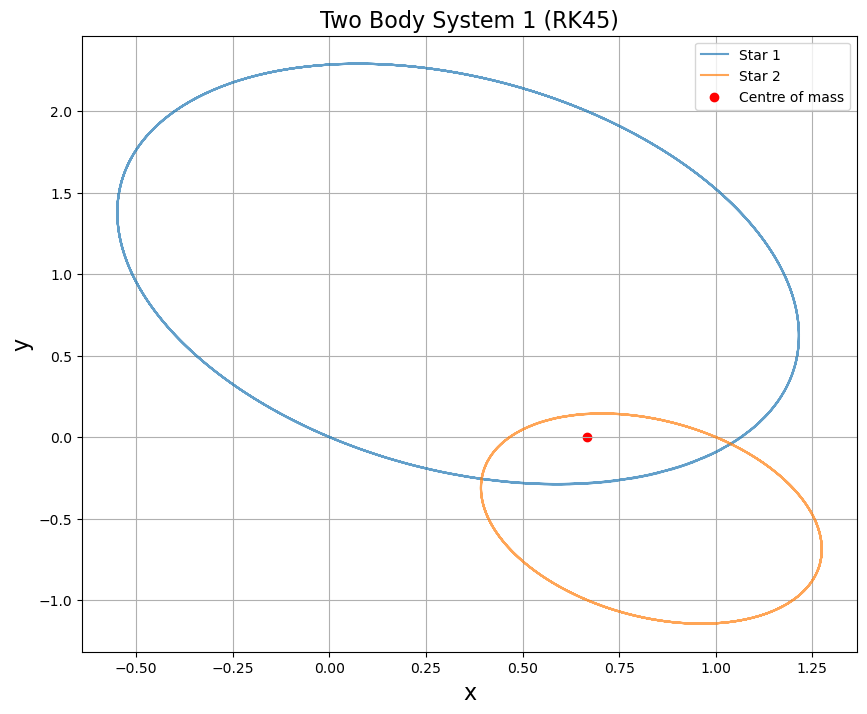

In [56]:
first_star = Star(name='Star 1', mass=0.25, starting_position=np.array([0,0]), starting_velocity=np.array([-0.5,0.5]))
second_star = Star(name='Star 2', mass=0.50, starting_position=np.array([1,0]), starting_velocity=np.array([0.25,-0.25]))

two_body_system = StellarSystem(max_time=100, N_time_steps=1000, integration_method='RK45', name='Two Body System 1')

two_body_system.add_star(first_star)
two_body_system.add_star(second_star)

two_body_system.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,8))

two_body_system.plot_movement(ax)
two_body_system.plot_centre_of_mass(ax)

### Comparison between scipy's solve_ivp() and the midpoint method

Now we can compare the results of the two integration methods (scipy's solve_ivp() and the midpoint method). I'll use the same system as before. 

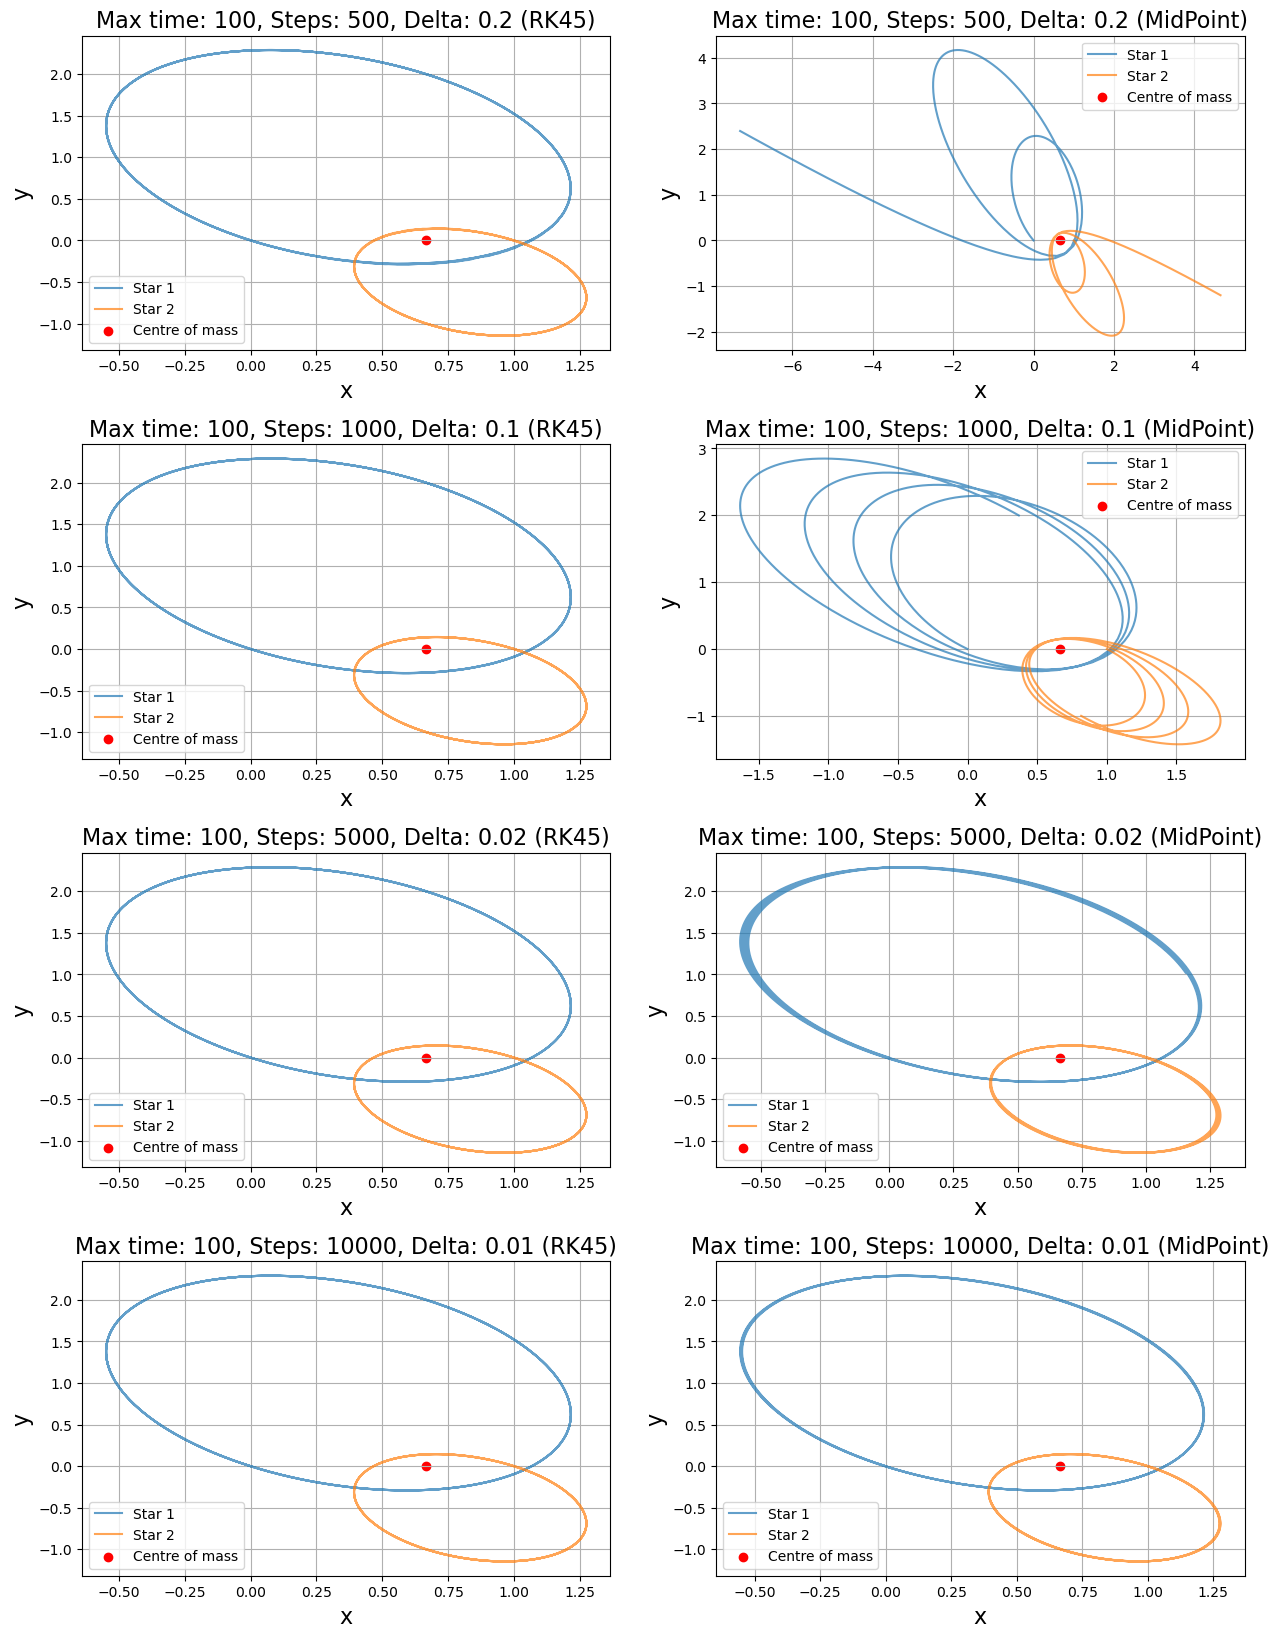

In [57]:
first_star = Star(name='Star 1', mass=0.25, starting_position=np.array([0,0]), starting_velocity=np.array([-0.5,0.5]))
second_star = Star(name='Star 2', mass=0.50, starting_position=np.array([1,0]), starting_velocity=np.array([0.25,-0.25]))

two_body_system = StellarSystem(max_time=100, N_time_steps=1000, integration_method='RK45', name='Two Body System')

two_body_system.add_star(first_star)
two_body_system.add_star(second_star)

fig, ax = plt.subplots(4, 2, figsize=(15,20))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

time_steps = [500, 1000, 5000, 10000]
for i, steps in enumerate(time_steps):
    for j,  method in enumerate(['RK45', 'MidPoint']):
        two_body_system.name = f"Max time: {100}, Steps: {steps}, Delta: {100/steps}"
        two_body_system.N_time_steps = steps
        two_body_system.integration_method = method

        two_body_system.calculate_movement()

        two_body_system.plot_movement(ax[i, j])
        two_body_system.plot_centre_of_mass(ax[i, j])

It is clear that solve_ivp() is much more accurate than the midpoint method. We can see that the midpoint method gets close to the true solution only when $deltaT$ is very small - $0.02$ or less. On the other hand, solve_ivp() is accurate even when $deltaT = 0.2$. 

It's interesting to note that the midpoint solutions start diverging after the two stars pass eachother (around the centre of mass). This is because at that part of their orbits, the acceleration is very large, and a lot of points are required to accurately model the system. In comparison to the midpoint method, RK45 is able to handle this situation much better as it chooses the step size adaptively.

### Convergence

Now we can check the convergence of the midpoint method. The midpoint method is a second-order method, so we should see that halfing the step size should quarter the error. For the error, I decided to take the total distance (in the form of the Euclidean Norm) between the current and previous solution. I plotted two systems: in one the max time was $50$ and in the other it was $250$. I did this because I wanted to see how the error develops as the stars go around their orbits multiple times. For each of the two systems, I took 4 different step sizes: $0.1$, $0.05$, $0.025$ and $0.0125$. When plotting the errors, I decided to take the log-scale, as it is more clear to see how they develop.

Let's check out the results:

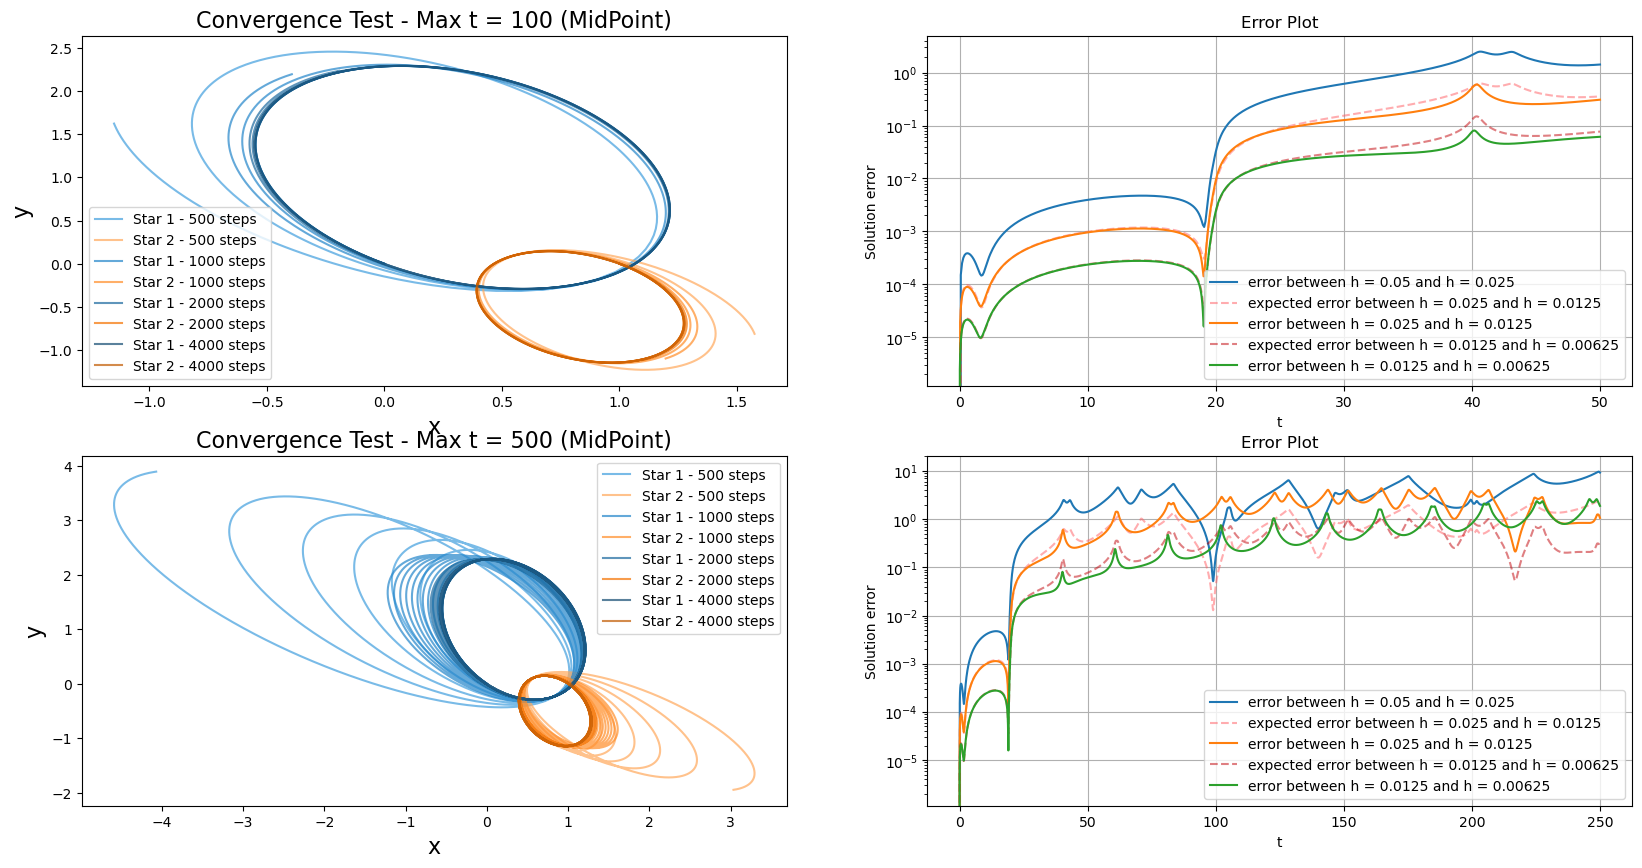

In [58]:
# Test the integrator for the midpoint method - error should decrease 
# by factor of 4 as it is second order
order = 2.0 ** 2.0

first_star = Star(name='First', mass=0.25, starting_position=np.array([0,0]), starting_velocity=np.array([-0.5,0.5]))
second_star = Star(name='Second', mass=0.50, starting_position=np.array([1,0]), starting_velocity=np.array([0.25,-0.25]))

two_body_system = StellarSystem(integration_method='MidPoint', name='Convergence Test - Max t = 100', max_time=100)
two_body_system_2 = StellarSystem(integration_method='MidPoint', name='Convergence Test - Max t = 500', max_time=100)

two_body_system.add_star(first_star)
two_body_system.add_star(second_star)
two_body_system_2.add_star(first_star)
two_body_system_2.add_star(second_star)

fig, ax = plt.subplots(2, 2, figsize=(20,10))

N_steps_vector = [500, 1000, 2000, 4000]
colors = [
    ["#419ede", "#ffa85b"],  # Light Blue and its complementary Orange
    ["#2385ca", "#ff8d28"],  # Medium Blue and its complementary Orange
    ["#1b699e", "#f47200"],
    ["#144c73", "#c15a00"]  # Dark Blue and its complementary Orange
]

for isteps, N_steps in enumerate(N_steps_vector) :

    two_body_system.max_time = 50
    two_body_system_2.max_time = 250
    two_body_system.N_time_steps = N_steps 
    two_body_system_2.N_time_steps = N_steps * 5
    two_body_system.colors = colors[isteps]
    two_body_system_2.colors = colors[isteps]
    two_body_system.calculate_movement()
    two_body_system_2.calculate_movement()
    first_star.name = f"Star 1 - {N_steps} steps"
    second_star.name = f"Star 2 - {N_steps} steps"
    h = two_body_system.delta_t
    h = two_body_system_2.delta_t

    two_body_system.plot_movement(ax[0, 0])
    two_body_system_2.plot_movement(ax[1, 0])

    if isteps > 0 :
        # Need to take every other entry for the finer resolution so the
        # size of the vectors match

        norms = np.array([])
        norms_2 = np.array([])
        for i in range(0, old_solution.shape[1]):
            diff = sum([np.linalg.norm(two_body_system.y_solution[[star_index*4, star_index*4 + 1], 2*i] - old_solution[[star_index*4, star_index*4 + 1], i], axis=0) for star_index in range(0, 2)])
            norms = np.append(norms,diff)

        for i in range(0, old_solution_2.shape[1]):
            diff_2 = sum([np.linalg.norm(two_body_system_2.y_solution[[star_index*4, star_index*4 + 1], 2*i] - old_solution_2[[star_index*4, star_index*4 + 1], i], axis=0) for star_index in range(0, 2)])
            norms_2 = np.append(norms_2,diff_2)

        ax[0, 1].plot(two_body_system.t_solution[::2], norms,
                    label="error between h = " + str(h) + " and h = " + str(h/2))  
        
        ax[1, 1].plot(two_body_system_2.t_solution[::2], norms_2,
                    label="error between h = " + str(h) + " and h = " + str(h/2))

        if isteps == 1 :
            ax[0, 1].plot(two_body_system.t_solution[::2], norms / order, '--', 
                    label="expected error between h = " + str(h/2) + " and h = " + str(h/4), color='#ff5b60', alpha=0.5)
            ax[1, 1].plot(two_body_system_2.t_solution[::2], norms_2 / order, '--',
                    label="expected error between h = " + str(h/2) + " and h = " + str(h/4), color='#ff5b60', alpha=0.5)
        if isteps == 2 :
            ax[0, 1].plot(two_body_system.t_solution[::2], norms / order, '--', 
                    label="expected error between h = " + str(h/2) + " and h = " + str(h/4), color='#c10006', alpha=0.5)
            ax[1, 1].plot(two_body_system_2.t_solution[::2], norms_2 / order, '--',
                    label="expected error between h = " + str(h/2) + " and h = " + str(h/4), color='#c10006', alpha=0.5)
    old_solution = two_body_system.y_solution
    old_solution_2 = two_body_system_2.y_solution

ax[0,1].grid()
ax[1,1].grid()
ax[0,1].legend()
ax[1,1].legend()
ax[0,1].set_ylabel("Solution error")
ax[1,1].set_ylabel("Solution error")
ax[0,1].set_title("Error Plot")
ax[1,1].set_title("Error Plot")
ax[0,1].set_yscale("log")
ax[1,1].set_yscale("log")
ax[0,1].set_xlabel("t")
ax[1,1].set_xlabel("t");

In the first system (with $max time = 50$) we see that as we half the time step, the error quartered which is how we expect it. However, in the second system (with $max time = 250$) where the stars go around their orbits multiple times, we notice that the error isn't necessarily reduced by a factor of 4. This is perhaps so because the longer simulation compounds the errors over time and we need to take even smaller time steps to reach solutions where the error decreases as expected.

### Phase Plot

The next thing needed to do is plot the phase plot. Here, again, I'll use the same system as before. Below I plotted the phase plots of the two stars. 

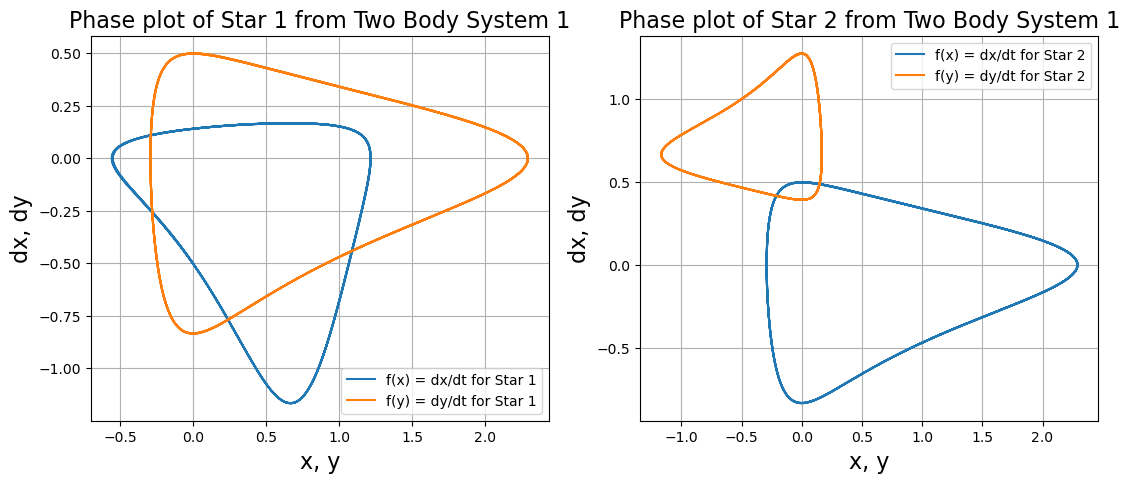

In [59]:
# 2-body problem [0,0,0,0.5] and [1,0,0,-0.5] work well
first_star = Star(name='Star 1', mass=0.25, starting_position=np.array([0,0]), starting_velocity=np.array([-0.5,0.5]))
second_star = Star(name='Star 2', mass=0.50, starting_position=np.array([1,0]), starting_velocity=np.array([0.25,-0.25]))

two_body_system = StellarSystem(max_time=100, N_time_steps=10000, integration_method='MidPoint', name='Two Body System 1')

two_body_system.add_star(first_star)
two_body_system.add_star(second_star)

two_body_system.calculate_movement()

fig, ax = plt.subplots(1, 2, figsize=(13,5))

two_body_system.plot_phase_plot(ax[0], 0)
two_body_system.plot_phase_plot(ax[1], 1)

The phase plot confirms the elliptical nature of the orbits. The closed loops tell us that the energy in the system is conserved and the system is stable.

Additionally, I found initial conditions under which the orbits are perfect circles. I found the solution using this [thread on StackExchange](https://math.stackexchange.com/questions/9324/two-body-problem-circular-orbits). Here are the plots of the orbits and the phase plot:

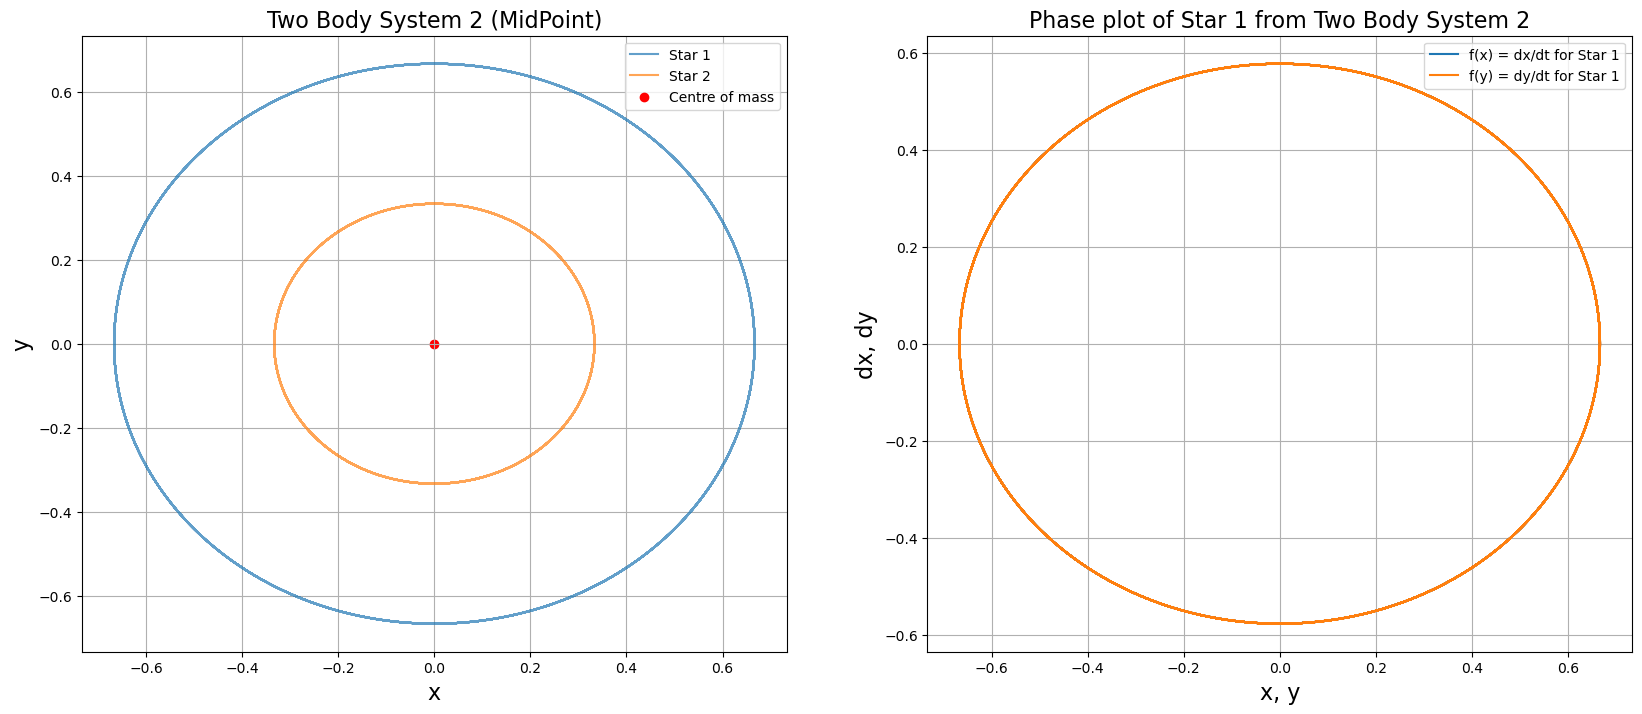

In [60]:
# 2-body problem [0,0,0,0.5] and [1,0,0,-0.5] work well
first_star = Star(name='Star 1', mass=0.25, starting_position=np.array([0,-2/3]), starting_velocity=np.array([0.5773502691896257,0]))
second_star = Star(name='Star 2', mass=0.50, starting_position=np.array([0,1/3]), starting_velocity=np.array([-0.28867513459481287,0]))

two_body_system = StellarSystem(max_time=100, N_time_steps=10000, integration_method='MidPoint', name='Two Body System 2')

two_body_system.add_star(first_star)
two_body_system.add_star(second_star)

two_body_system.calculate_movement()

fig, ax = plt.subplots(1, 2, figsize=(20,8))
two_body_system.plot_movement(ax[0])
two_body_system.plot_centre_of_mass(ax[0])
two_body_system.plot_phase_plot(ax[1], 0)


The phase plots of the x and y coordinates of Star 1 coincide confirming that the orbit is circular.

---
## Part 2: Periodic Solutions

I used a mix between RK45 and the midpoint method and both work good.
### Cris Moore's solution - 3 body choreography

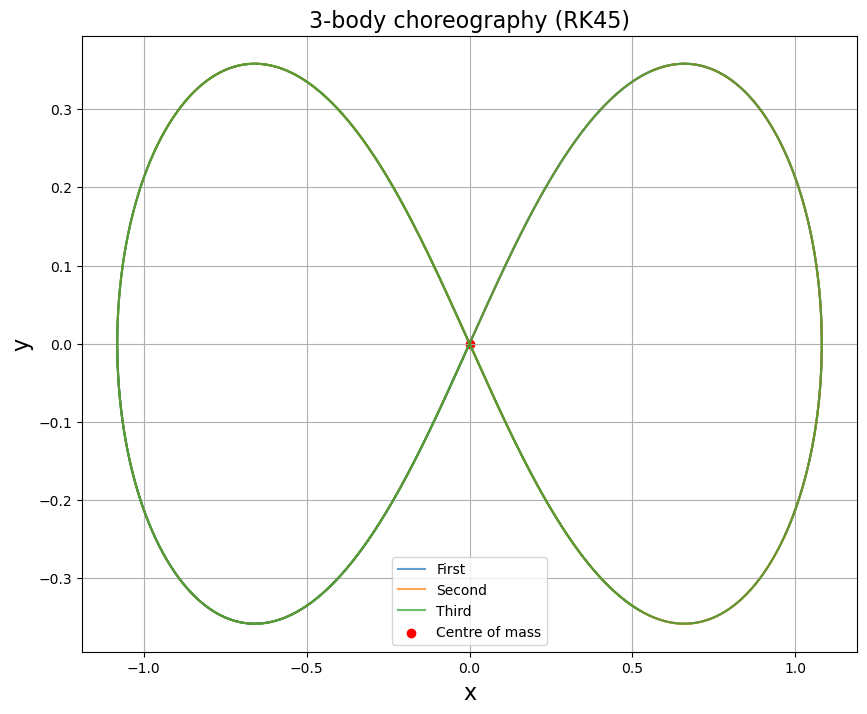

In [61]:
first_star = Star(name='First', mass=1, starting_position=np.array([0.97000436,-0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
second_star = Star(name='Second', mass=1, starting_position=np.array([-0.97000436,0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
third_star = Star(name='Third', mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([-0.93240737,-0.86473146]))

tbp_infinity = StellarSystem(max_time=10, N_time_steps=10000, integration_method='RK45', name='3-body choreography')

tbp_infinity.add_star(first_star)
tbp_infinity.add_star(second_star)
tbp_infinity.add_star(third_star)

tbp_infinity.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,8))

tbp_infinity.plot_movement(ax)
tbp_infinity.plot_centre_of_mass(ax)

### Butterfly III ([link](http://three-body.ipb.ac.rs/sol.php?id=10))

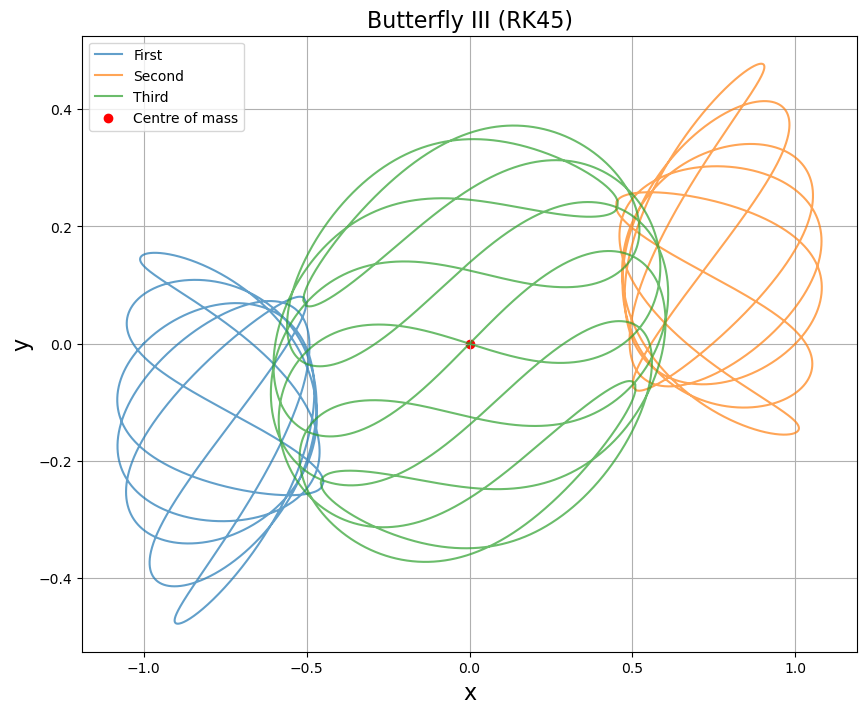

In [62]:
first_star = Star(name='First', mass=1, starting_position=np.array([-1,0]), starting_velocity=np.array([0.405916,0.230163]))
second_star = Star(name='Second', mass=1, starting_position=np.array([1,0]), starting_velocity=np.array([0.405916,0.230163]))
third_star = Star(name='Third', mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([-2 * 0.405916,-2 * 0.230163]))

tbp_butterfly = StellarSystem(max_time=13.865763, N_time_steps=10000, integration_method='RK45', name='Butterfly III')

tbp_butterfly.add_star(first_star)
tbp_butterfly.add_star(second_star)
tbp_butterfly.add_star(third_star)

tbp_butterfly.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,8))


tbp_butterfly.plot_movement(ax)
tbp_butterfly.plot_centre_of_mass(ax)

# I set max time to the period of the system so the final positions coincide with the starting positions
# tbp_butterfly.plot_final_positions(ax)        # Uncomment to try

### Yin-Yang 2a ([link](http://three-body.ipb.ac.rs/sol.php?id=15))

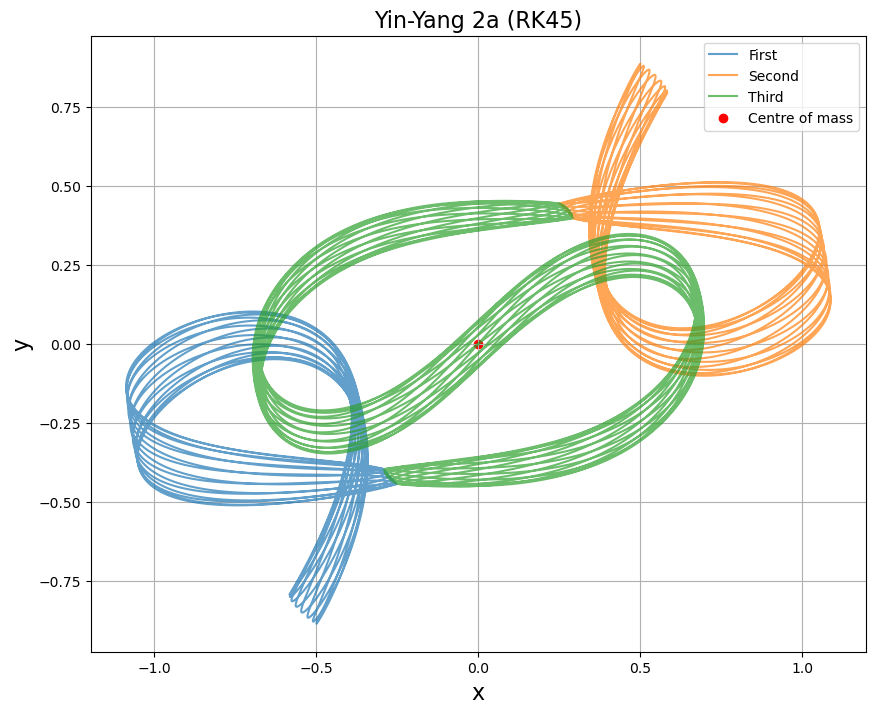

In [63]:
first_star = Star(name='First', mass=1, starting_position=np.array([-1,0]), starting_velocity=np.array([0.416822,0.330333]))
second_star = Star(name='Second', mass=1, starting_position=np.array([1,0]), starting_velocity=np.array([0.416822,0.330333]))
third_star = Star(name='Third', mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([-2 * 0.416822,-2 * 0.330333]))

tbp_yinyang = StellarSystem(max_time=55.789829, N_time_steps=100000, integration_method='RK45', name='Yin-Yang 2a')

tbp_yinyang.add_star(first_star)
tbp_yinyang.add_star(second_star)
tbp_yinyang.add_star(third_star)

tbp_yinyang.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,8))


tbp_yinyang.plot_movement(ax)
tbp_yinyang.plot_centre_of_mass(ax)

# I set max time to the period of the system so the final positions, however in this case they do not coincide perfectly with the starting positions
# tbp_yinyang.plot_final_positions(ax)        # Uncomment to try

### Carles Simo 5-body choreography (not sure whether he found it) ([pdf](https://www.math.uni-bielefeld.de/~rehmann/ECM/cdrom/3ecm/pdfs/pant3/simo.pdf))
I tried this solution to test whether my code can handle more than 3 bodies. I had to find the initial conditions by equating the center of mass and the angular momentum to 0 as the paper doesn't give all the initial conditions. 

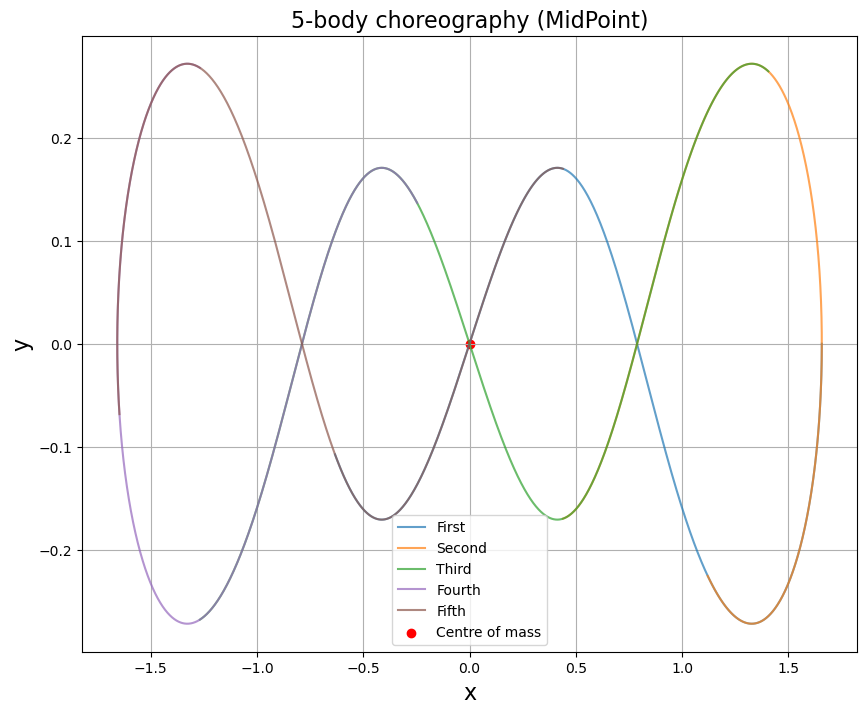

In [64]:
# 5 body problem
pos = np.array([[1.657666, -0.],[0.439775, -0.169717], [-1.268608,-0.267651], [-1.268608,0.267651], [0.439775, 0.169717]])
vel = np.array([[0, -0.5937852933570453], [1.822785, 0.128248], [1.271564, 0.168645], [-1.271564, 0.168645], [-1.822785, 0.128248]])

first_star = HyperGiant(name='First', mass=1, starting_position=pos[0], starting_velocity=vel[0])
second_star = HyperGiant(name='Second', mass=1, starting_position=pos[1], starting_velocity=vel[1])
third_star = HyperGiant(name='Third', mass=1, starting_position=pos[2], starting_velocity=vel[2])
fourth_star = HyperGiant(name='Fourth', mass=1, starting_position=pos[3], starting_velocity=vel[3])
fifth_star = HyperGiant(name='Fifth', mass=1, starting_position=pos[4], starting_velocity=vel[4])

fbp_infinity = StellarSystem(max_time=2, N_time_steps=10000, integration_method='MidPoint', name='5-body choreography')

fbp_infinity.add_star(first_star)
fbp_infinity.add_star(second_star)
fbp_infinity.add_star(third_star)
fbp_infinity.add_star(fourth_star)
fbp_infinity.add_star(fifth_star)

fbp_infinity.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,8))

fbp_infinity.plot_movement(ax)
fbp_infinity.plot_centre_of_mass(ax)

One interesting thing to note is that the centre of mass fluctuates slightly for all of these periodic solutions. This is perhaps due to rounding errors as it doesn't happen for any of the other systems I tested. Here are the centers of mass for the 4 periodic solutions:

In [65]:
print("Three body problem Infinity:")
print(tbp_infinity.centre_of_mass)
print("Three body problem Butterfly III:")
print(tbp_butterfly.centre_of_mass)
print("Three body problem Yin Yang 2a:")
print(tbp_yinyang.centre_of_mass)
print("Five body problem Infinity:")
print(fbp_infinity.centre_of_mass)

Three body problem Infinity:
[[ 0.00000000e+00  2.96709995e-17 -2.79001359e-17 ... -7.40148683e-16
  -7.77156117e-16 -7.03141249e-16]
 [ 0.00000000e+00 -2.89120579e-19 -3.18032637e-18 ...  7.40148683e-16
   7.40148683e-16  7.40148683e-16]]
Three body problem Butterfly III:
[[ 0.00000000e+00 -4.11996826e-17 -1.15648232e-17 ... -2.72929827e-15
  -2.73392420e-15 -2.71542048e-15]
 [ 0.00000000e+00 -3.61400724e-20  0.00000000e+00 ...  2.23605856e-14
   2.23640551e-14  2.23640551e-14]]
Three body problem Yin Yang 2a:
[[ 0.00000000e+00 -1.42211185e-17  1.69858340e-17 ...  2.62891560e-14
   2.62891560e-14  2.62937820e-14]
 [ 0.00000000e+00  0.00000000e+00  3.61400724e-20 ... -4.01239805e-13
  -4.01251370e-13 -4.01261778e-13]]
Five body problem Infinity:
[[4.44089210e-17 0.00000000e+00]
 [6.66133815e-17 2.82657175e-11]
 [8.88178420e-17 5.65314406e-11]
 ...
 [3.06421555e-15 2.82600648e-07]
 [3.08642001e-15 2.82628914e-07]
 [3.06421555e-15 2.82657180e-07]]


For all of these systems, the initial center of mass is at $[0,0]$, except for the five-body Infinity solution. This is perhaps because I had to find the initial conditions myself, and some rounding errors occured. However, the center of mass is still very close to $[0,0]$. Interestingly, the sum of the initial possitions gives $[0, 0]$ even though the first coordinates of the center of mass aren't $[0, 0]$.

In [66]:
sum(np.array([[1.657666, -0.],[0.439775, -0.169717], [-1.268608,-0.267651], [-1.268608,0.267651], [0.439775, 0.169717]]))

array([0., 0.])

---
## Part 3: HyperGiants
Finally, we have the hypergiants. I plotted two very similar scenarios. In both cases, the center of mass is stationary. The first plot shows the largest star assimilating the smallest one, after which the two bodies remain going in different directions. Here is the plot:

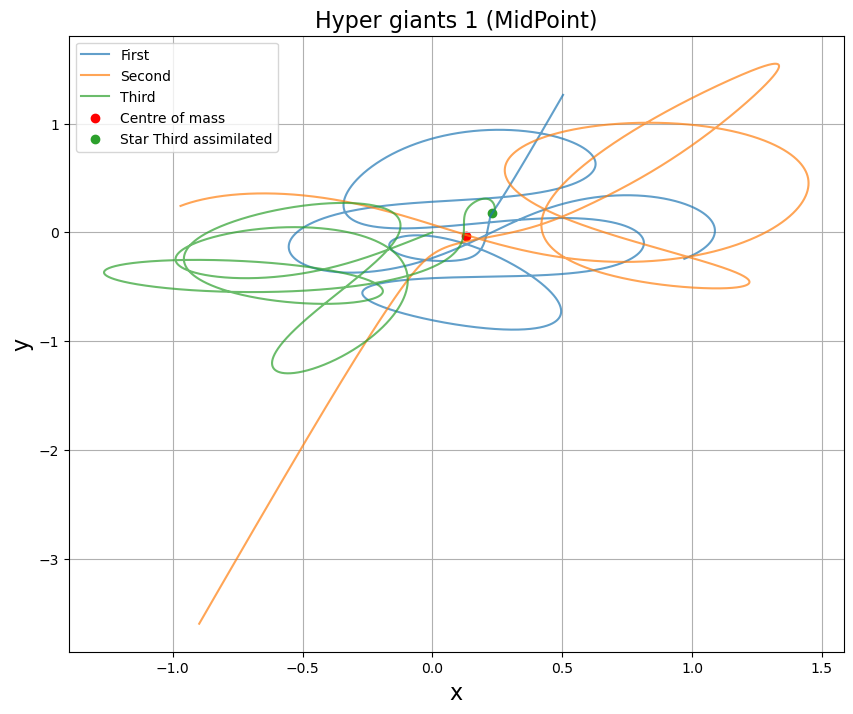

In [67]:
# 3-body problem - hypergiants
first_star = HyperGiant(name='First', mass=1.2, starting_position=np.array([0.97000436,-0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
second_star = HyperGiant(name='Second', mass=0.8, starting_position=np.array([-0.97000436,0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
third_star = HyperGiant(name='Third', mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([-0.93240737,-0.86473146]))

tbp_stellar_system = StellarSystem(max_time=16, N_time_steps=10000, integration_method="MidPoint", name='Hyper giants 1')

tbp_stellar_system.add_star(first_star)
tbp_stellar_system.add_star(second_star)
tbp_stellar_system.add_star(third_star)

tbp_stellar_system.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,8))

tbp_stellar_system.plot_movement(ax)
tbp_stellar_system.plot_centre_of_mass(ax)
tbp_stellar_system.plot_collision_coordinates(ax)

For the second plot, we see a very similar behavior, however, after the first collision, the two remaining bodies manage to attract eachother and collide. Interestingly, in the end we are left with a single body, which remains perfectly still in space and falls exactly on the center of mass. This testifies to the accuracy of the code. Here is the plot:

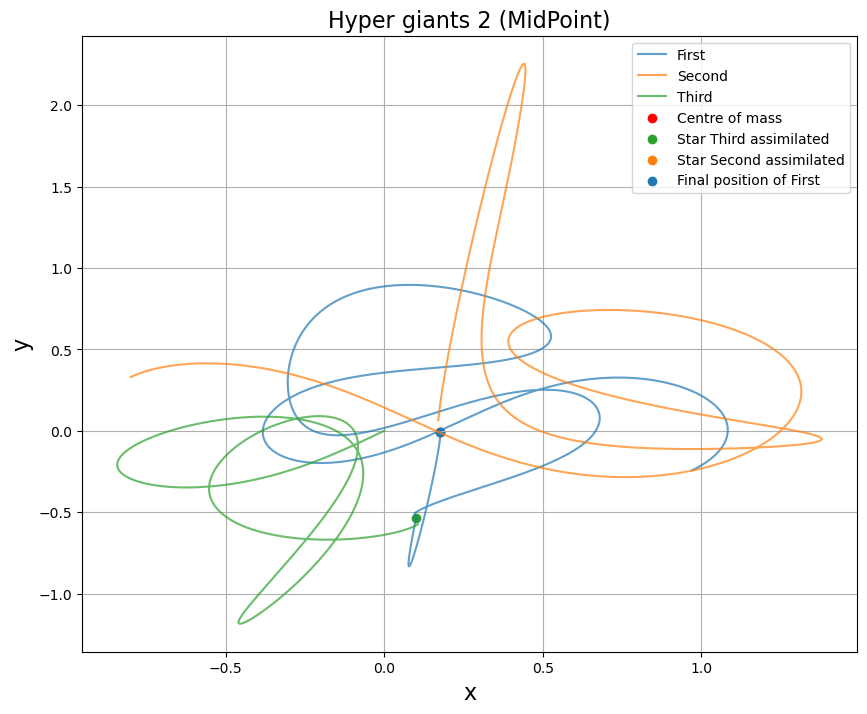

In [68]:
first_star = HyperGiant(name='First', mass=1.2, starting_position=np.array([0.970,-0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
second_star = HyperGiant(name='Second', mass=0.8, starting_position=np.array([-0.8,0.33]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
third_star = HyperGiant(name='Third', mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([-0.93240737,-0.86473146]))

tbp_stellar_system = StellarSystem(max_time=50, N_time_steps=10000, integration_method="MidPoint", name='Hyper giants 2')

tbp_stellar_system.add_star(first_star)
tbp_stellar_system.add_star(second_star)
tbp_stellar_system.add_star(third_star)

tbp_stellar_system.calculate_movement()

fig, ax = plt.subplots(1, 1, figsize=(10,8))

tbp_stellar_system.plot_movement(ax)
tbp_stellar_system.plot_centre_of_mass(ax)
tbp_stellar_system.plot_collision_coordinates(ax)

# Plot final positions of the remaining star to show that it coincides with the centre of mass
tbp_stellar_system.plot_final_positions(ax)